In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os

from matplotlib.dates import DateFormatter

In [16]:
def getMostRecentRun(path="/exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb"):
    
    # select the most recent run in the runs directory
    files = [ f for f in os.listdir(path) if "measChannelBaselines" in f ]
    times = [ f.split("_")[0] for f in os.listdir(path) if "measChannelBaselines" in f ]
    runs  = [ f.split("_")[-1].lstrip('run').rstrip('.csv') for f in os.listdir(path) if "measChannelBaselines" in f ]
    times = [ int(t) for t in times]
    tmax = max(times)
    rmax = max(runs)
    
    # load the file as a dataframe
    file = path + "/" + str(tmax) + "_measChannelBaselines_run" + str(rmax) + ".csv"
    df = pd.read_csv(file, sep=",")
    
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")

    print("Reading " + file + " ...")
    
    return df, tmax, rmax

In [20]:
def getRun(run, path="/exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb"):
    
    files = [ f for f in os.listdir(path) if str(run) in f ]
    timestamp = files[0].split("_")[0]
    
    # load the files as a dataframe
    file = path + "/" + files[0]
    df = pd.read_csv(file, sep=",")
    
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")

    print("Reading " + file + " ...")
    
    return df, run, timestamp

In [4]:
import sqlite3

def readSqlitedb(database="/cvmfs/icarus.opensciencegrid.org/products/icarus/icarus_data/v09_79_01/icarus_data/database/ChannelMapICARUS_20230829.db",
                 table="pmt_placements_29aug2023"):

    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect(database)
    df = pd.read_sql_query("SELECT * from {}".format(table), con)
    con.close()
    return df

def getChannelID(db, board, digitizer_channel):
    
    ch = db.loc[(db['digitizer_label']==board) & (db['digitizer_ch_number']==digitizer_channel), ['channel_id']]
    return ch.values[0][0]

def getDigitizer(db, channel):
    
    _SELCH = (db.channel_id==channel)
    return db[_SELCH].digitizer_label.values[0], db[_SELCH].digitizer_ch_number.values[0]

In [5]:
### PLOT BASELINE TIME EVOLUTION: shows time evolution for channels of the same board
### all channels from the same board in the same plot
def plot_baseline_evolution(df):
    
    db = readSqlitedb()   
    boards = np.unique(db["digitizer_label"].to_numpy())
    
    for board in boards:
        
        fig = plt.figure(dpi=200)
    
        for digch in range(15):

            ch = getChannelID(db,board,digch)
            lab = "Ch " + str(ch)
            _SEL = (df.ch==ch)
        
            plt.plot(df[_SEL].datetime,df[_SEL].baseline,label=lab)

        plt.xlabel("Time")
        plt.ylabel("Baseline [ADC]")
        #plt.ylim((14740,14800))
        plt.title(board)
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.grid(alpha=0.5)
        plt.show()

In [42]:
### PLOT BASELINE FOR EACH CHANNEL: averaged over the first 20 events in each channel (as seen, not much evolution)
def plot_baseline_spread(df, setting, run, xmax, xmin, n=100):
    
    plt.figure(dpi=200)
    baselines = []
    
    for ch in range(360):
    
        _SEL = (df.ch==ch)
        bs = df[_SEL].baseline.head(n)
        baselines.append(np.median(bs))
    
    binsize = 10
    xbins = int((xmax-xmin)/binsize)
    
    plt.hist(baselines, bins=xbins, range=(xmin,xmax), histtype='bar', lw=2, label="Mean: {:.1f}\nMedian: {:.1f}\nStd: {:.1f}".format(np.mean(baselines),np.median(baselines),np.std(baselines)))
    plt.xlabel("Baseline [ADC]")
    plt.ylabel("# channels")
    plt.title("Baseline spread (first "+str(n)+" events) - Run " + str(run))
    
    plt.axvline(x=setting, color="red", linestyle='dotted')
    
    plt.grid()
    plt.legend()
    plt.show()

In [43]:
def plot_nonequalized_distance(df, config, xmax, xmin, n=100, limit=20):
    
    configpath = "/exp/icarus/data/users/mvicenzi/pmt-baselines/configdb"
    configfile = configpath + "/" + config
    conf = pd.read_csv(configfile, sep=",")
    
    plt.figure(dpi=200)
    db = readSqlitedb()   
    baselines = []
    
    for ch in range(360):

        dig, dig_ch = getDigitizer(db,ch)
        #print(dig, dig_ch)
        
        _SEL = (df.ch==ch)
        _SELC = (conf.board==dig)&(conf.digitizer_channel==dig_ch)

        target = conf[_SELC].target_baseline.values[0]
        bs = df[_SEL].baseline.head(n)
        baselines.append(np.median(bs)-target)
    
    binsize = 10
    xbins = int((xmax-xmin)/binsize)
    
    plt.hist(baselines, bins=xbins, range=(xmin,xmax), histtype='bar', lw=2, label="Mean: {:.1f}\nMedian: {:.1f}\nStd: {:.1f}".format(np.mean(baselines),np.median(baselines),np.std(baselines)))
    plt.xlabel("Measured Baseline - Target Baseline [ADC]")
    plt.ylabel("# channels")
    plt.title("Baseline spread (first "+str(n)+" events) - Run " + str(run))
    
    plt.axvline(x=0., color="red", linestyle='dotted')
    
    plt.grid()
    plt.legend()
    plt.show()

## Check most-recent baseline status 

In [54]:
#df, run, timestamp = getMostRecentRun()

df, run, timestamp = getRun(10932)

Reading /exp/icarus/data/users/mvicenzi/pmt-baselines/baselinesdb/1698152140_measChannelBaselines_run10932.csv ...


In [55]:
df.head()

,event,timestamp,ch,baseline,datetime
0,1,1698152140,0,14743.23047,2023-10-24 12:55:40
1,1,1698152140,1,14744.84668,2023-10-24 12:55:40
2,1,1698152140,2,14744.13477,2023-10-24 12:55:40
3,1,1698152140,3,14744.70801,2023-10-24 12:55:40
4,1,1698152140,4,14745.58789,2023-10-24 12:55:40


In [56]:
#plot_baseline_evolution(df)

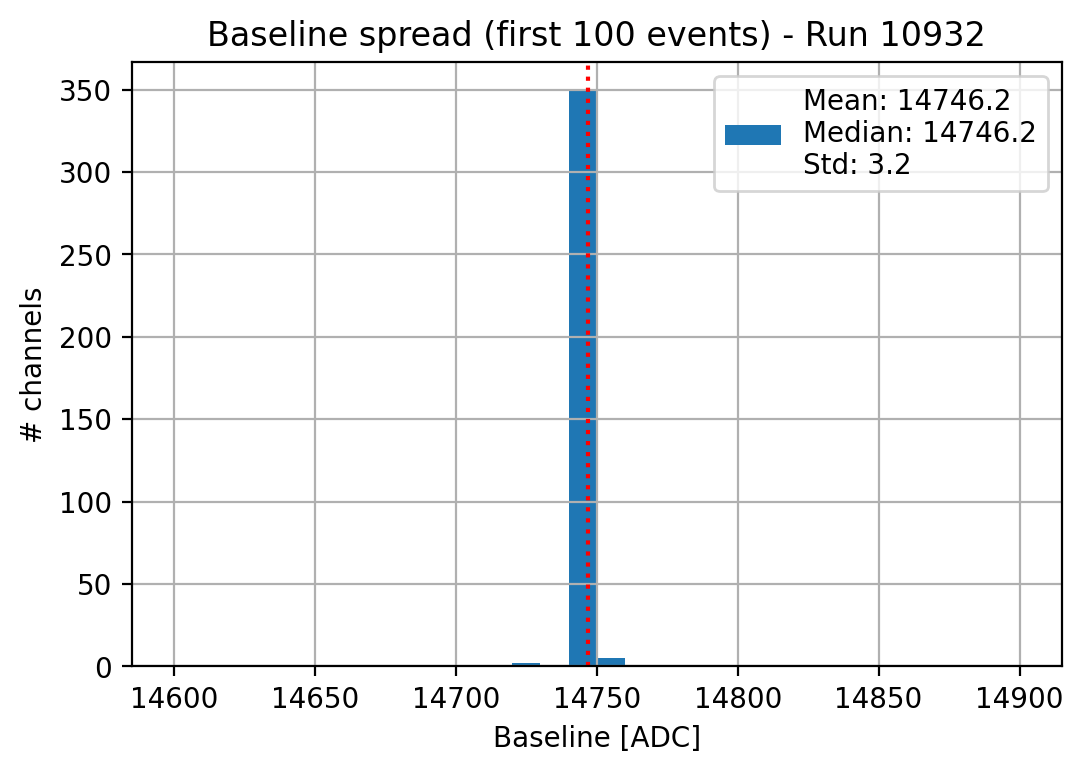

In [59]:
setting = 14747
xmin = 14600
xmax = 14900
plot_baseline_spread(df, setting, run, xmax, xmin)

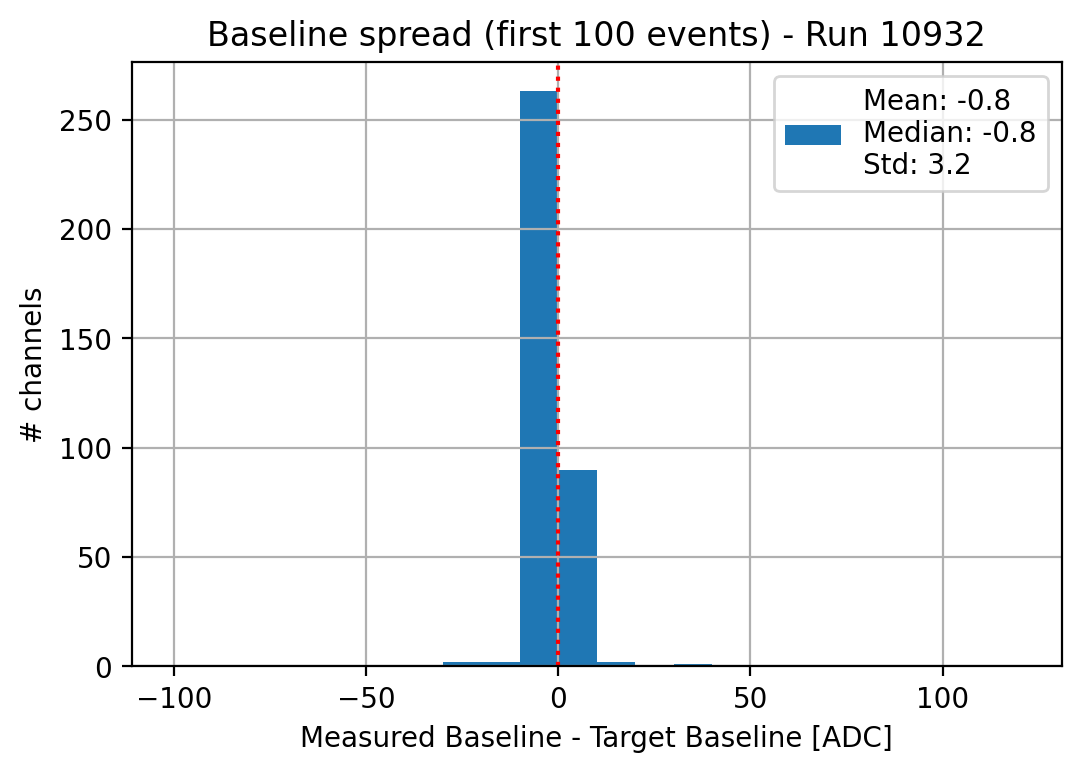

In [60]:
config = "PMT_Standard_Run3_data.csv"
xmin = -100
xmax = 120
plot_nonequalized_distance(df, config, xmax, xmin)